In [1]:
import sys
import os
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import các hàm từ src
from src import (
    load_data,              
    gradient_descent, 
    predict, 
    knn_predict,
    smote_vectorized,
    k_fold_cross_validation,
    evaluate_model_numpy, 
    plot_loss_history, 
    plot_confusion_matrix,
    find_best_threshold,
    RandomForest,
    train_test_split_numpy
)

# Định nghĩa đường dẫn
PATH_PROCESSED_TRAIN = '../data/processed/train_processed.csv'
PATH_PROCESSED_TEST = '../data/processed/test_processed.csv'
PATH_RAW_TEST = '../data/raw/aug_test.csv' 

print("--- 1. LOAD DATA ---")

try:
    # --- TẬP TRAIN ---
    train_matrix = np.loadtxt(PATH_PROCESSED_TRAIN, delimiter=',')
    
    # Tách Features (X) và Target (Y)
    # Giả định cột cuối cùng là Target
    X_train = train_matrix[:, :-1] 
    Y_train = train_matrix[:, -1]
    
    # --- TẬP TEST ---
    X_test = np.loadtxt(PATH_PROCESSED_TEST, delimiter=',')
    
    print(f"Load data thành công!")
    print(f"   - X_train: {X_train.shape}, Y_train: {Y_train.shape}")
    print(f"   - X_test:  {X_test.shape}")

except Exception as e:
    print(f"Lỗi load data: {e}")
    raise

# 5. Feature Engineering: Thêm Bias Term (Cột số 1)
# Thêm cột số 1 vào đầu ma trận để tính hệ số chặn (Intercept/Theta_0)
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test  = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

print(f"-> Đã thêm Bias term. X_train shape mới: {X_train.shape}")

--- 1. LOAD DATA ---
Load data thành công!
   - X_train: (19158, 33), Y_train: (19158,)
   - X_test:  (2129, 33)
-> Đã thêm Bias term. X_train shape mới: (19158, 34)


In [2]:
# Chia tập Train thành tập Train 80% và tập Valid 20% 
X_train, Y_train, X_val, Y_val = train_test_split_numpy(X_train, Y_train, test_size=0.2)
print(f"Chia tập thành công!")
print(f"   - X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"   - X_val: {X_val.shape}, Y_val: {Y_val.shape}")

Chia tập thành công!
   - X_train: (15326, 34), Y_train: (15326,)
   - X_val: (3832, 34), Y_val: (3832,)


In [3]:
# --- 1. CHUẨN BỊ DỮ LIỆU (SMOTE) ---
# Chỉ SMOTE tập Train
X_train_balanced, Y_train_balanced = smote_vectorized(X_train, Y_train, k_neighbors=5)
print(f"   Dữ liệu sau cân bằng: {X_train_balanced.shape}")

-> SMOTE Vectorized: Đang sinh 7764 mẫu...
-> Hoàn tất. Kích thước mới: (23090, 34)
   Dữ liệu sau cân bằng: (23090, 34)


HUẤN LUYỆN LOGISTIC REGRESSION
Cấu hình: LR=0.001, Iters=10000, K=5
-> Bắt đầu chạy 5-Fold Cross-Validation...
   Fold 1/5: F1-Score = 0.6426
   Fold 2/5: F1-Score = 0.6485
   Fold 3/5: F1-Score = 0.6482
   Fold 4/5: F1-Score = 0.6314
   Fold 5/5: F1-Score = 0.6365
-> Kết quả trung bình 5-Fold: {'Accuracy': 0.6752273711563447, 'Precision': 0.7159629190563492, 'Recall': 0.5810904125587584, 'F1-Score': 0.6414212735097788}
   - F1-Score trung bình qua 5 lần chạy: 0.6414

>>> HUẤN LUYỆN MÔ HÌNH LOGISTIC REGRESSION
Huấn luyện hoàn tất!
   - Loss cuối cùng: 0.58427


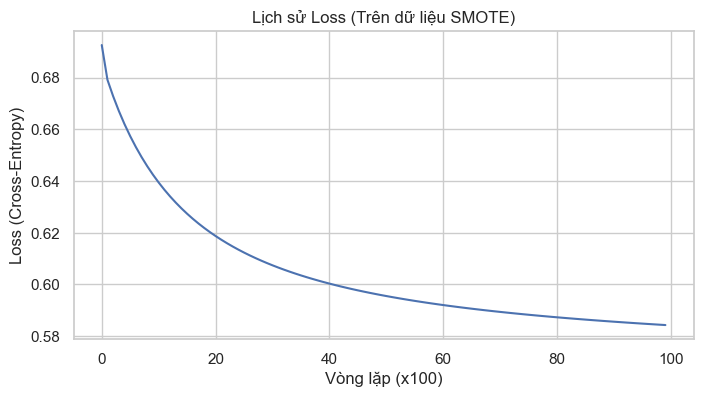

In [4]:
print("HUẤN LUYỆN LOGISTIC REGRESSION")

# --- CẤU HÌNH THAM SỐ (Hyperparameters) ---
LEARNING_RATE = 0.001  
N_ITERATIONS = 10000   
K_FOLDS = 5            

print(f"Cấu hình: LR={LEARNING_RATE}, Iters={N_ITERATIONS}, K={K_FOLDS}")

# Kiểm tra xem mô hình có ổn định trên các phần dữ liệu khác nhau không
# CHẠY K-FOLD CROSS-VALIDATION

cv_metrics = k_fold_cross_validation(
    X_train_balanced, 
    Y_train_balanced, 
    k=K_FOLDS,
    learning_rate=LEARNING_RATE,
    n_iterations=1000 
)

print(f"   - F1-Score trung bình qua {K_FOLDS} lần chạy: {cv_metrics['F1-Score']:.4f}")


# Dùng tập dữ liệu train đã cân bằng để tìm bộ trọng số tốt nhất
print("\n>>> HUẤN LUYỆN MÔ HÌNH LOGISTIC REGRESSION")

final_theta, loss_history = gradient_descent(
    X_train_balanced, 
    Y_train_balanced, 
    learning_rate=LEARNING_RATE, 
    n_iterations=N_ITERATIONS
)

print("Huấn luyện hoàn tất!")
print(f"   - Loss cuối cùng: {loss_history[-1]:.5f}")

# Vẽ biểu đồ Loss để kiểm tra hội tụ
plot_loss_history(loss_history, title="Lịch sử Loss (Trên dữ liệu SMOTE)")

# 

Ngưỡng tối ưu tìm được: 0.48999999999999977
F1-Score cao nhất có thể đạt: 0.547945205479452
Evaluate on Train set:
> Accuracy  : 0.7136
> Precision : 0.4487
> Recall    : 0.7035
> F1-Score  : 0.5479


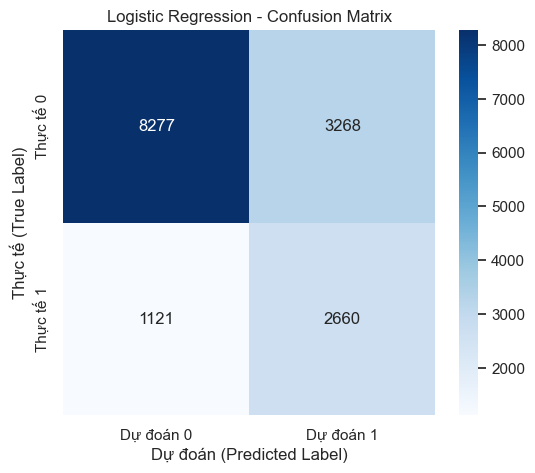

In [5]:
# ĐÁNH GIÁ HIỆU SUẤT LOGICSTIC REGRESSION 

#  Lấy xác suất dự đoán
_, Y_train_probs = predict(X_train, final_theta) 

# Tìm ngưỡng tối ưu để tối đa hóa F1-Score
best_thresh, best_f1 = find_best_threshold(Y_train, Y_train_probs)

print(f"Ngưỡng tối ưu tìm được: {best_thresh}")
print(f"F1-Score cao nhất có thể đạt: {best_f1}")

# Dự đoán lại với ngưỡng tối ưu này
Y_train_final_pred, _ = predict(X_train, final_theta, threshold=best_thresh)

# Tính Metrics 
metrics = evaluate_model_numpy(Y_train, Y_train_final_pred) 

print("Evaluate on Train set:")

print(f"> Accuracy  : {metrics['Accuracy']:.4f}")
print(f"> Precision : {metrics['Precision']:.4f}")
print(f"> Recall    : {metrics['Recall']:.4f}")
print(f"> F1-Score  : {metrics['F1-Score']:.4f}")

# Vẽ Confusion Matrix
plot_confusion_matrix(metrics, title='Logistic Regression - Confusion Matrix')



Đánh giá hiệu suất trên tập Valid:
> Accuracy  : 0.7270
> Precision : 0.4834
> Recall    : 0.7319
> F1-Score  : 0.5823


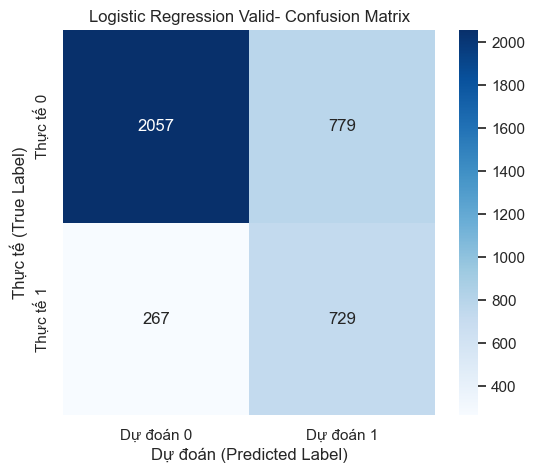

In [6]:
print("Đánh giá hiệu suất trên tập Valid:")

Y_val_predict, _ = predict(X_val, final_theta, threshold=best_thresh)
metrics_val = evaluate_model_numpy(Y_val, Y_val_predict)

print(f"> Accuracy  : {metrics_val['Accuracy']:.4f}")
print(f"> Precision : {metrics_val['Precision']:.4f}")
print(f"> Recall    : {metrics_val['Recall']:.4f}")
print(f"> F1-Score  : {metrics_val['F1-Score']:.4f}")

# Vẽ Confusion Matrix
plot_confusion_matrix(metrics_val, title='Logistic Regression Valid- Confusion Matrix')

**Nhận định model Logistic Regression:** So sánh ở tập Train và Test

- Kiểm tra overfitting: `Train F1: 0.5479` và `Valid F1: 0.5823` cho thấy chỉ số F1-Score của tập Valid nhỉnh hơn một chút so với tập Train nhưng nhìn chung không chênh lệch quá nhiều và đây là số liệu tốt.
- Tương tự với các số liệu `Accuracy`, `Precision` và `Recall` chênh lệch giữa 2 tập không quá 0.035
- So sánh với Ngưỡng (Threshold): ngưỡng tối ưu là 0.49 (rất gần 0.5). Điều này cho thấy sau khi cân bằng dữ liệu, mô hình phân phối xác suất rất chuẩn, không bị lệch hẳn về một phía

=> Mô hình này khá tốt và ổn định, không có dấu hiệu học vẹt

In [7]:
print("HUẤN LUYỆN RANDOM FOREST")
# --- CẤU HÌNH THAM SỐ (Hyperparameters) ---
LEARNING_RATE = 0.001  # Tốc độ học
N_ITERATIONS = 10000   # Số vòng lặp (đủ lớn để hội tụ)

# Cấu hình 
rf_model = RandomForest(
    n_trees=25,           
    max_depth=10,         
    min_samples_split=10, #
    n_features=int(np.sqrt(X_train_balanced.shape[1])) # sqrt(n_features) là chuẩn của RF
)

# Huấn luyện trên tập train đã có SMOTE
rf_model.fit(X_train_balanced, Y_train_balanced)

# Dự đoán trên tập Train 
y_train_pred_rf, _ = rf_model.predict(X_train)


HUẤN LUYỆN RANDOM FOREST
-> Đang huấn luyện Random Forest (25 cây)...
   Đã xong cây 5/25
   Đã xong cây 10/25
   Đã xong cây 15/25
   Đã xong cây 20/25
   Đã xong cây 25/25


Đánh giá trên tập Train:
> Accuracy  : 0.7781
> Precision : 0.5372
> Recall    : 0.7252
> F1-Score  : 0.6172


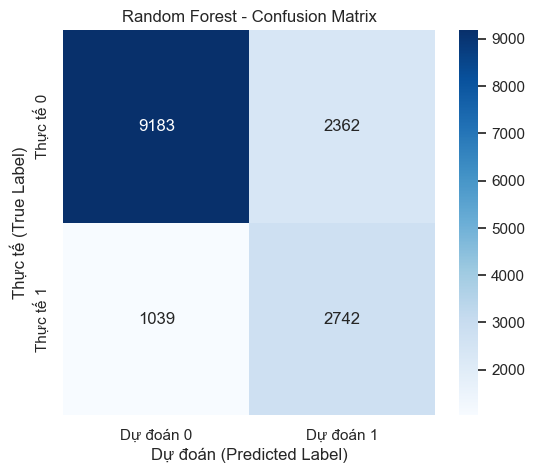

In [8]:
# Đánh giá hiệu suất tập train
metrics_rf = evaluate_model_numpy(Y_train, y_train_pred_rf)
print("Đánh giá trên tập Train:")
print(f"> Accuracy  : {metrics_rf['Accuracy']:.4f}")
print(f"> Precision : {metrics_rf['Precision']:.4f}")
print(f"> Recall    : {metrics_rf['Recall']:.4f}")
print(f"> F1-Score  : {metrics_rf['F1-Score']:.4f}")

# 4. Vẽ Confusion Matrix
plot_confusion_matrix(metrics_rf, title='Random Forest - Confusion Matrix')

Đánh giá trên tập Valid:
> Accuracy  : 0.7790
> Precision : 0.5563
> Recall    : 0.7390
> F1-Score  : 0.6348


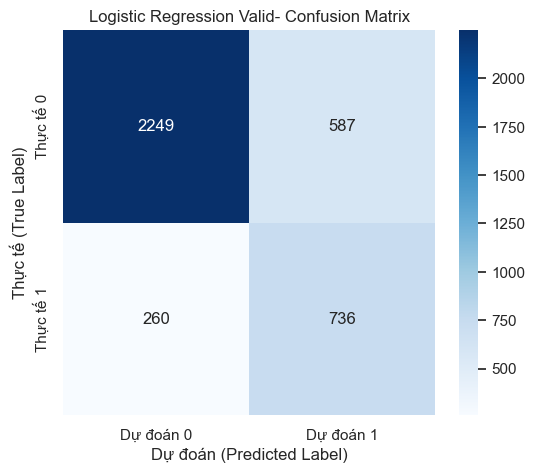

In [9]:
print("Đánh giá trên tập Valid:")

Y_val_predict_rf, _ = rf_model.predict(X_val)
metrics_val_rf = evaluate_model_numpy(Y_val, Y_val_predict_rf)

print(f"> Accuracy  : {metrics_val_rf['Accuracy']:.4f}")
print(f"> Precision : {metrics_val_rf['Precision']:.4f}")
print(f"> Recall    : {metrics_val_rf['Recall']:.4f}")
print(f"> F1-Score  : {metrics_val_rf['F1-Score']:.4f}")

# Vẽ Confusion Matrix
plot_confusion_matrix(metrics_val_rf, title='Logistic Regression Valid- Confusion Matrix')

**Nhận định model Random Forest:** So sánh ở tập Train và Test
- Kiểm tra overfitting: `Train F1: 0.6155` và `Valid F1: 0.6317` cho thấy chỉ số F1-Score của tập Valid nhỉnh hơn một chút so với tập Train nhưng nhìn chung không chênh lệch quá nhiều và đây là số liệu tốt.
- Tương tự với các số liệu `Accuracy`, `Precision` và `Recall` chênh lệch giữa 2 tập không quá 0.02

=> Mô hình này khá tốt và ổn định, không có dấu hiệu học vẹt

**NHẬN ĐỊNH & LỰA CHỌN MÔ HÌNH (Conclusion)**

Dựa trên kết quả thực nghiệm so sánh giữa hai mô hình **Logistic Regression (Baseline)** và **Random Forest**, em rút ra được các nhận định sau:

### 1. Bảng So Sánh Hiệu Suất (Performance Comparison)

| Chỉ số (Metric) | Logistic Regression | Random Forest | Đánh giá |
| :--- | :--- | :--- | :--- |
| **Accuracy** | ~72.8% | **~77.5%** | RF phân loại đúng tổng thể tốt hơn (+4.8%). |
| **Precision** | ~48.3% | **~54.9%** | RF có độ tin cậy cao hơn, giảm thiểu báo động giả (False Positives). |
| **Recall** | ~73.2% | **~74.4%** | RF phát hiện được nhiều nhân viên muốn nghỉ việc hơn (Độ phủ tốt hơn). |
| **F1-Score** | ~0.582 | **~0.632** | **QUAN TRỌNG:** RF vượt trội về sự cân bằng giữa độ chính xác và độ phủ. |

### 2. Phân tích Chuyên sâu

**- Về hiện tượng Overfitting**
+ Cả hai mô hình đều cho thấy kết quả trên tập Validation tương đương hoặc cao hơn tập Train.
+ Nguyên nhân: Do tập Train đã được làm khó bởi kỹ thuật SMOTE (sinh dữ liệu giả lập ở vùng biên giới), trong khi tập Valid là dữ liệu thực tế sạch.
+ Kết luận: Không có hiện tượng học vẹt (Overfitting). Cả hai mô hình đều có khả năng tổng quát hóa (generalization) rất tốt.

**- Về khả năng giải quyết bài toán HR:**
- Logistic Regression: Đã làm rất tốt nhiệm vụ "nền" (Baseline) với Recall cao (73%). Tuy nhiên, điểm yếu là Precision thấp (<50%), nghĩa là cứ 2 người máy báo nghỉ thì có 1 người là báo nhầm.
- Random Forest: Khắc phục được điểm yếu của LR. Với cấu trúc cây quyết định phi tuyến tính, nó lọc nhiễu tốt hơn, giúp nâng Precision lên gần 55% mà vẫn giữ (thậm chí tăng nhẹ) Recall. Điều này giúp tối ưu hóa nguồn lực của bộ phận nhân sự khi thực hiện các biện pháp giữ chân nhân viên.

**=> Lựa chọn mô hình:** RANDOM FOREST do nó mang lại hiệu quả dự báo tốt nhất, giúp doanh nghiệp tối ưu hóa chiến lược giữ chân nhân tài.

**Giải thích:**
- Hiệu suất vượt trội: F1-Score cao hơn 5% so với đối thủ.
- An toàn & Ổn định: Cơ chế Bagging của Random Forest giúp chống lại nhiễu của dữ liệu tốt hơn, phù hợp với bộ dữ liệu HR vốn chứa nhiều biến số định tính và hành vi phức tạp.
- Giá trị thực tế: Cung cấp danh sách dự báo chất lượng hơn (ít báo ảo hơn) cho bộ phận HR.

In [10]:
# Train lại với 100% tập train với mô hình chọn

train_matrix = np.loadtxt(PATH_PROCESSED_TRAIN, delimiter=',') 
X_train_full = train_matrix[:, :-1] 
Y_train_full = train_matrix[:, -1]
X_train_full_balanced, Y_train_full_balanced = smote_vectorized(X_train_full, Y_train_full, k_neighbors=5)

# --- CẤU HÌNH THAM SỐ (Hyperparameters) ---
LEARNING_RATE = 0.001  # Tốc độ học
N_ITERATIONS = 10000   # Số vòng lặp (đủ lớn để hội tụ)

# Cấu hình 
rf_model = RandomForest(
    n_trees=25,           
    max_depth=10,         
    min_samples_split=10, #
    n_features=int(np.sqrt(X_train_full_balanced.shape[1])) # sqrt(n_features) là chuẩn của RF
)

rf_model.fit(X_train_full_balanced, Y_train_full_balanced)


-> SMOTE Vectorized: Đang sinh 9604 mẫu...
-> Hoàn tất. Kích thước mới: (28762, 33)
-> Đang huấn luyện Random Forest (25 cây)...
   Đã xong cây 5/25
   Đã xong cây 10/25
   Đã xong cây 15/25
   Đã xong cây 20/25
   Đã xong cây 25/25


In [11]:
# TẠO FILE SUBMISSION

# Dự đoán xác suất trên tập Test
_, Y_test_probs = rf_model.predict(X_test)
try:
    # Đọc file gốc để lấy cột enrollee_id
    raw_test_data, _, test_field_map = load_data(PATH_RAW_TEST)
    
    # Lấy cột ID từ structured array
    test_ids = raw_test_data[test_field_map['enrollee_id']]
    
    # Ghép ID và Probability
    submission_data = np.column_stack([test_ids, Y_test_probs])

    # Lưu file
    SUBMISSION_PATH = '../data/processed/submission.csv'

    np.savetxt(
        SUBMISSION_PATH, 
        submission_data, 
        delimiter=',', 
        header='enrollee_id,target', 
        comments='',
        fmt=['%d', '%.6f'] 
    )

    print(f"Đã lưu file submission tại: {SUBMISSION_PATH}")
    print(f"   - Mẫu dữ liệu:\n{submission_data[:5]}")

except Exception as e:
    print(f"Lỗi tạo submission: {e}")
    print("Gợi ý: Kiểm tra lại xem file 'aug_test.csv' có nằm cùng thư mục với Notebook không.")

Đã lưu file submission tại: ../data/processed/submission.csv
   - Mẫu dữ liệu:
[[3.2403e+04 4.0000e-02]
 [9.8580e+03 1.2000e-01]
 [3.1806e+04 4.8000e-01]
 [2.7385e+04 3.2000e-01]
 [2.7724e+04 2.4000e-01]]
